In [1]:
import pandas as pd
import pydicom
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import os
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the CSV file
df = pd.read_csv('RSNA_breast_cancer_data.csv')

In [2]:
# Function to load DICOM images and resize them
def load_dicom_image(image_path, target_size=(224, 224)):  # Resize to 224x224 for ResNet101
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    
    # Convert grayscale to 3 channels by replicating the grayscale image
    image_rgb = np.stack([image_normalized] * 3, axis=-1)  # Replicate across 3 channels
    return image_rgb

# Load all the images and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

In [3]:
# Prepare data
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

In [4]:
images.shape

(2374, 224, 224, 3)

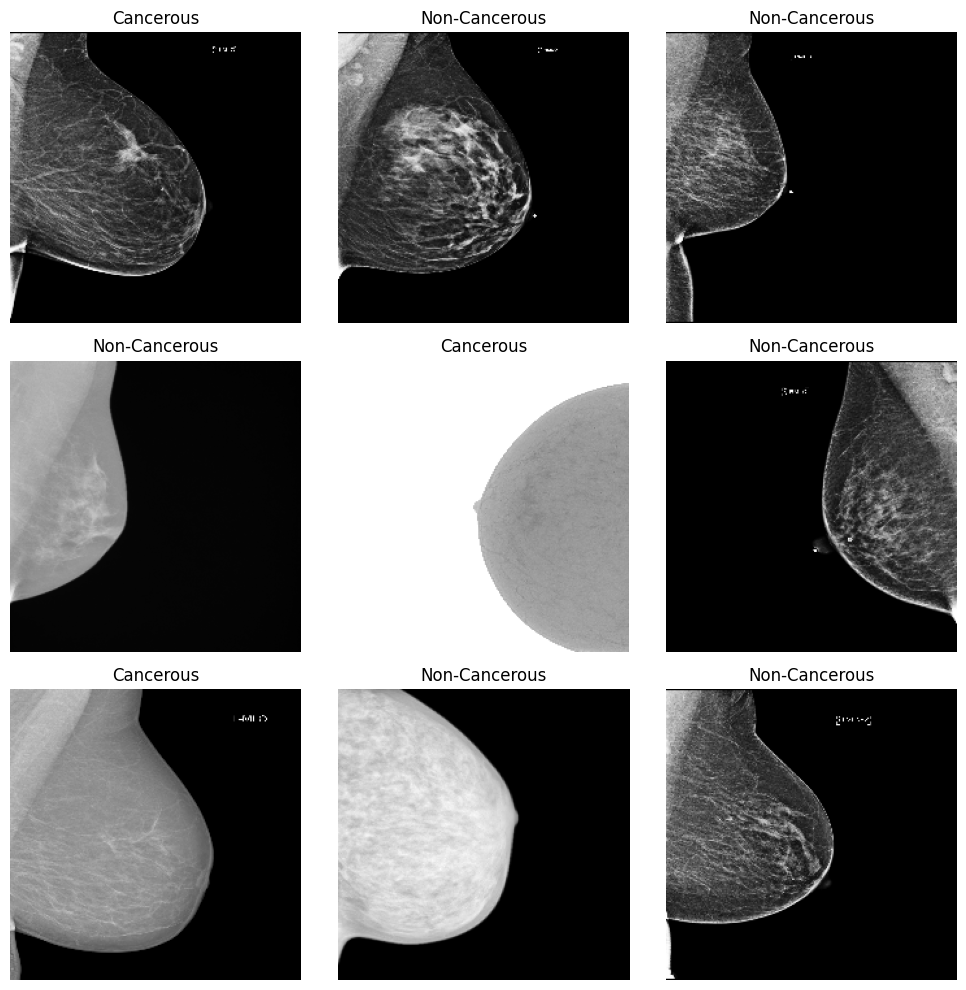

In [6]:
# Visualize 9 random images in a 3x3 grid from the 'images' array
import random
# Select 9 random indices to visualize
random_indices = random.sample(range(len(images)), 9)

# Create a figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop through the 9 random images
for i, ax in enumerate(axes.flat):
    # Get the corresponding image and label
    image_to_visualize = images[random_indices[i]]
    label = labels[random_indices[i]]
    
    # Plot the image
    ax.imshow(image_to_visualize.squeeze(), cmap='gray')  # Remove the channel dimension
    ax.set_title(f'{"Cancerous" if label == 1 else "Non-Cancerous"}')  # Display the label
    
    # Turn off axis for a cleaner look
    ax.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [5]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of the remaining data

# Use ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

# Flow the data using ImageDataGenerator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [8]:
# Load ResNet101 with pre-trained weights and exclude the top layers
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Build the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,920,577 (163.73 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [9]:
# Train the model using fit with ImageDataGenerator
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.5032 - loss: 0.8057 - val_accuracy: 0.5190 - val_loss: 0.6884
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5214 - loss: 0.7189 - val_accuracy: 0.6118 - val_loss: 0.6829
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.5139 - loss: 0.7148 - val_accuracy: 0.6076 - val_loss: 0.6799
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.5430 - loss: 0.6953 - val_accuracy: 0.5696 - val_loss: 0.6770
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.5016 - loss: 0.7077 - val_accuracy: 0.5949 - val_loss: 0.6758
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.5641 - loss: 0.6794 - val_accuracy: 0.5865 - val_loss: 0.6736
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.5829 - loss: 0.6768 - val_accuracy: 0.5696 - val_loss: 0.6727
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.5694 - loss: 0.6809 - val_accuracy: 0.5992 - v

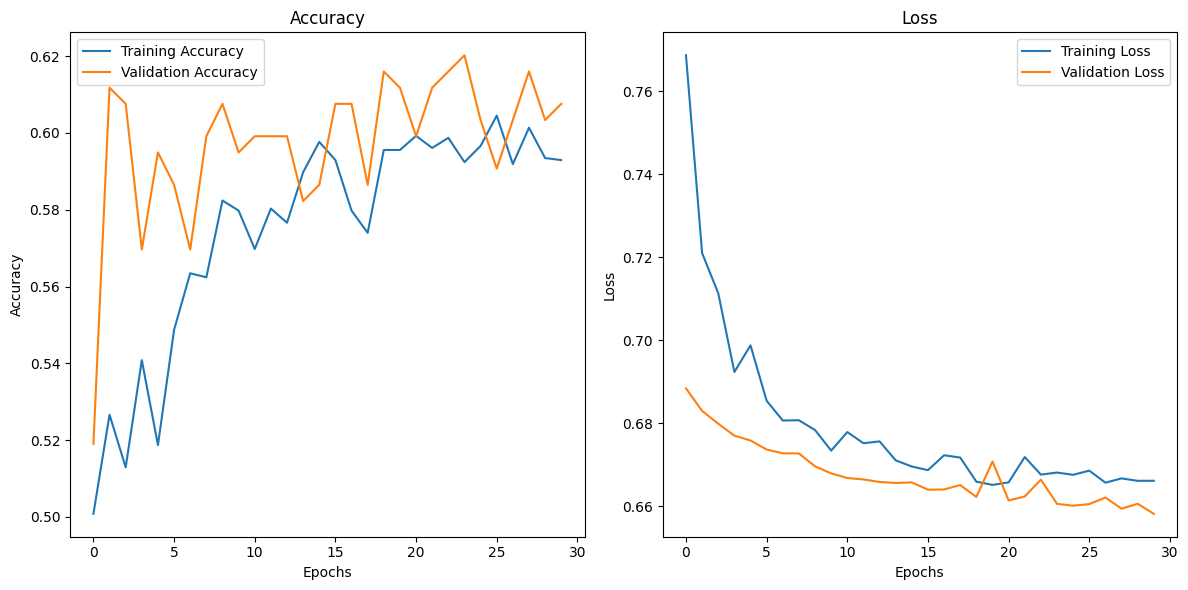

In [11]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Evaluate on test data after training is complete
test_generator = val_datagen.flow(X_test, y_test, batch_size=32)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"\nTest accuracy: {test_acc}")

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 - 12s - 2s/step - accuracy: 0.6513 - loss: 0.6516

Test accuracy: 0.651260495185852


8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


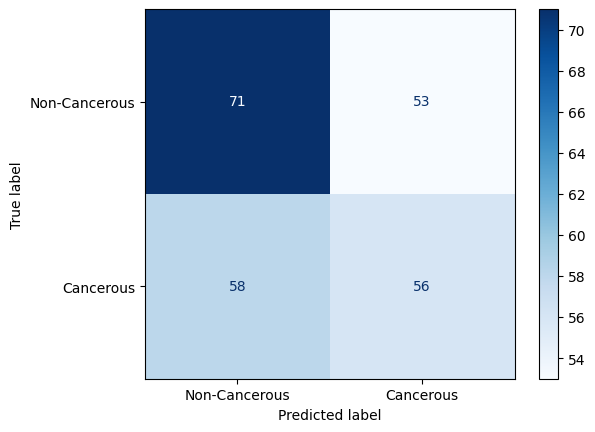

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
y_pred_probs = model.predict(test_generator)

# Convert probabilities to binary class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


## using PCA

In [ ]:
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

# Load ResNet101 with pre-trained weights and exclude the top layers
base_model2 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model2.trainable = False

# Create a model that outputs the features from the base model
feature_extractor = Model(inputs=base_model2.input, outputs=base_model2.output)

# Extract features for the training data
train_features = feature_extractor.predict(X_train)
val_features = feature_extractor.predict(X_val)
test_features = feature_extractor.predict(X_test)

# Flatten the features for PCA (Reshape to 2D)
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Apply PCA for dimensionality reduction (Choose n_components as per your preference)
pca = PCA(n_components=100)  # You can adjust the number of components based on your dataset
train_features_pca = pca.fit_transform(train_features_flat)
val_features_pca = pca.transform(val_features_flat)
test_features_pca = pca.transform(test_features_flat)

In [14]:
# Build a new model using the reduced features
model2 = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(train_features_pca.shape[1],)),  # Input shape after PCA
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model2.summary()

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model with PCA-transformed features
history2 = model2.fit(train_features_pca, y_train,
                    epochs=30,
                    validation_data=(val_features_pca, y_val))

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5114 - loss: 1.8814 - val_accuracy: 0.5190 - val_loss: 1.4145
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5031 - loss: 1.6260 - val_accuracy: 0.5316 - val_loss: 1.1193
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5207 - loss: 1.3367 - val_accuracy: 0.5865 - val_loss: 0.9274
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5529 - loss: 1.2152 - val_accuracy: 0.6287 - val_loss: 0.8176
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5735 - loss: 1.1056 - val_accuracy: 0.6582 - val_loss: 0.7542
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5885 - loss: 1.0173 - val_accuracy: 0.6709 - val_loss: 0.7123
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5831 - loss: 0.9891 - val_accuracy: 0.6624 - val_loss: 0.6910
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5881 - loss: 0.9445 - val_accuracy: 0.6751 - val_loss:

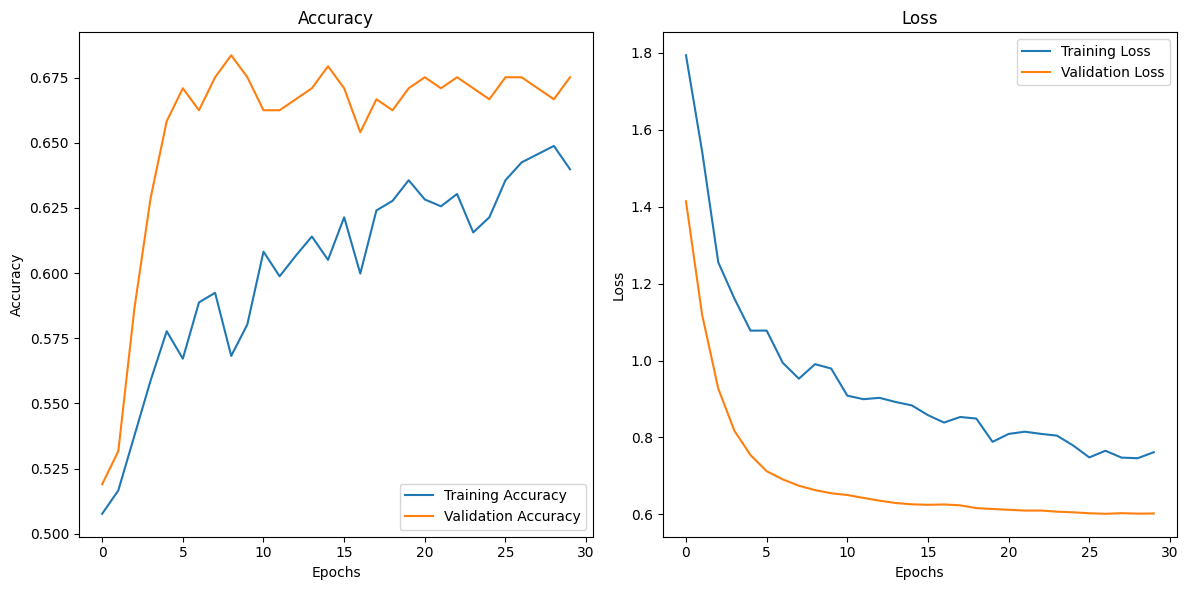

In [16]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# Evaluate on test data after training is complete
test_loss, test_acc = model2.evaluate(test_features_pca, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc}")

8/8 - 0s - 6ms/step - accuracy: 0.6597 - loss: 0.6189

Test accuracy: 0.6596638560295105


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


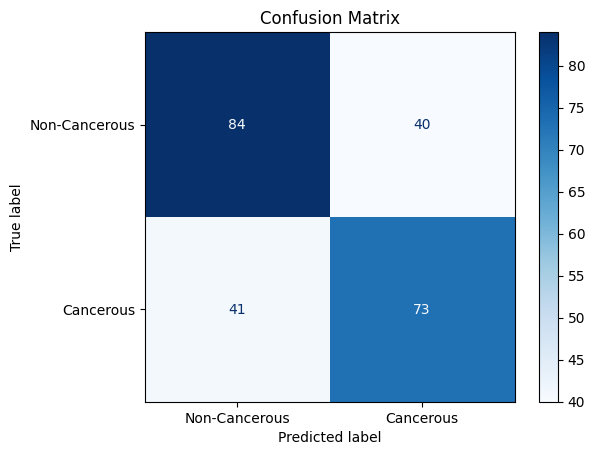

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_probs = model2.predict(test_features_pca)  # Get the predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class labels

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title('Confusion Matrix')
plt.show()

## Using LDA

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load ResNet101 with pre-trained weights and exclude the top layers
base_model3 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model3.trainable = False

# Create a model that outputs the features from the base model
feature_extractor3 = Model(inputs=base_model3.input, outputs=base_model3.output)

# Extract features for the training data
train_features = feature_extractor3.predict(X_train)
val_features = feature_extractor3.predict(X_val)
test_features = feature_extractor3.predict(X_test)

# Flatten the features for LDA (Reshape to 2D)
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Apply LDA for dimensionality reduction (choose n_components as per your dataset)
lda = LinearDiscriminantAnalysis(n_components=1)  # LDA reduces to 1 component for binary classification
train_features_lda = lda.fit_transform(train_features_flat, y_train)
val_features_lda = lda.transform(val_features_flat)
test_features_lda = lda.transform(test_features_flat)

60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


In [22]:
# Build a new model using the reduced features
model3 = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(train_features_lda.shape[1],)),  # Input shape after LDA
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model with LDA-transformed features
history3 = model3.fit(train_features_lda, y_train,
                    epochs=30,
                    validation_data=(val_features_lda, y_val))

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3694 - loss: 11.9877 - val_accuracy: 0.5190 - val_loss: 127.6123
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4545 - loss: 8.8522 - val_accuracy: 0.5190 - val_loss: 105.1997
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5562 - loss: 5.3407 - val_accuracy: 0.5190 - val_loss: 82.2765
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6646 - loss: 3.2321 - val_accuracy: 0.5232 - val_loss: 62.0630
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 2.0740 - val_accuracy: 0.5401 - val_loss: 79.5734
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - loss: 1.4508 - val_accuracy: 0.5401 - val_loss: 101.9133
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.7270 - val_accuracy: 0.5401 - val_loss: 119.0000
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9031 - loss: 0.4999 - val_accuracy: 0.5401

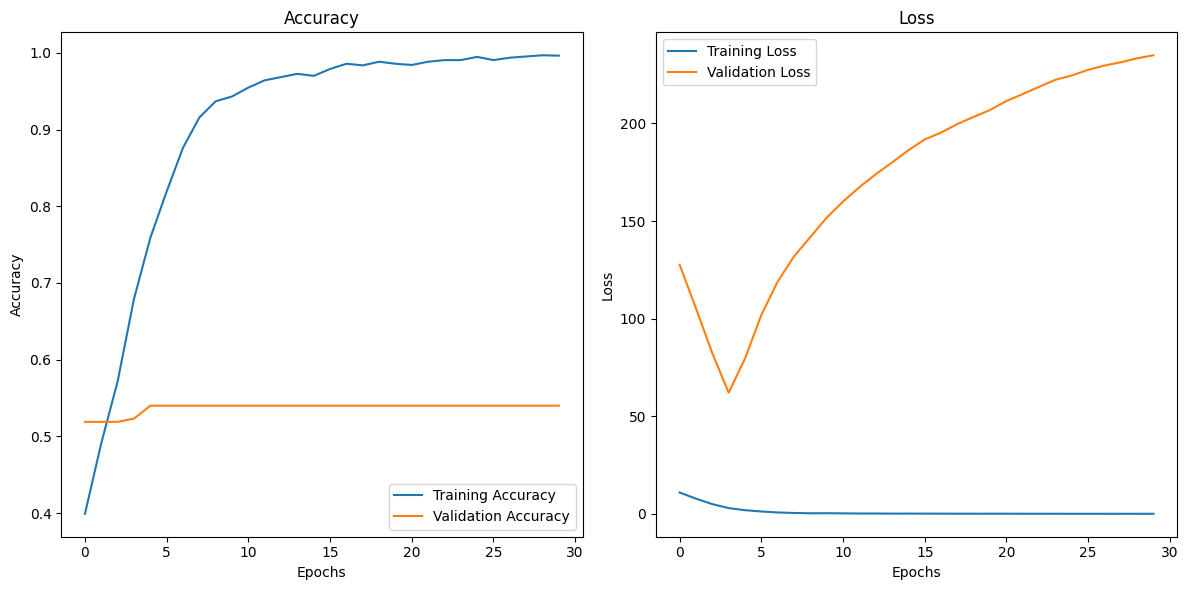

In [24]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate on test data after training is complete
test_loss, test_acc = model3.evaluate(test_features_lda, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc}")

8/8 - 0s - 5ms/step - accuracy: 0.5126 - loss: 282.6474

Test accuracy: 0.5126050710678101


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


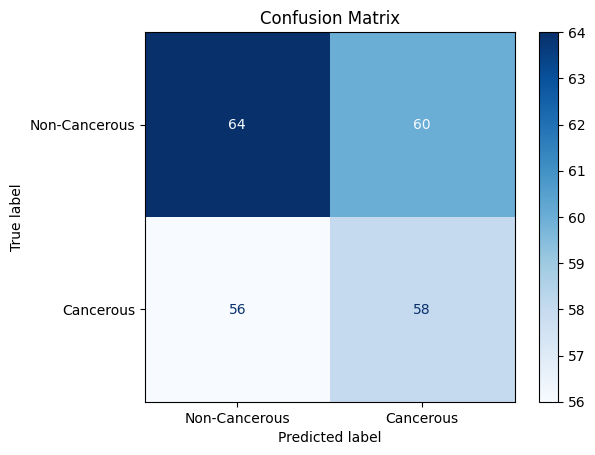

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_probs = model3.predict(test_features_lda)  # Get the predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class labels

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title('Confusion Matrix')
plt.show()

## Using VGG16

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 with pre-trained weights and exclude the top layers
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model_vgg16.trainable = False

# Build the model
model_vgg16 = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Display model summary
model_vgg16.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
# Train the model using fit with ImageDataGenerator
history = model_vgg16.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5109 - loss: 0.7331 - val_accuracy: 0.5612 - val_loss: 0.6910
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4987 - loss: 0.7179 - val_accuracy: 0.5274 - val_loss: 0.6900
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5034 - loss: 0.7214 - val_accuracy: 0.5359 - val_loss: 0.6889
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5027 - loss: 0.7109 - val_accuracy: 0.5781 - val_loss: 0.6871
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5057 - loss: 0.7116 - val_accuracy: 0.5190 - val_loss: 0.6868
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.5200 - loss: 0.7012 - val_accuracy: 0.6076 - val_loss: 0.6845
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5115 - loss: 0.6994 - val_accuracy: 0.5654 - val_loss: 0.6836
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5234 - loss: 0.6915 - val_accuracy: 0.5949 - v

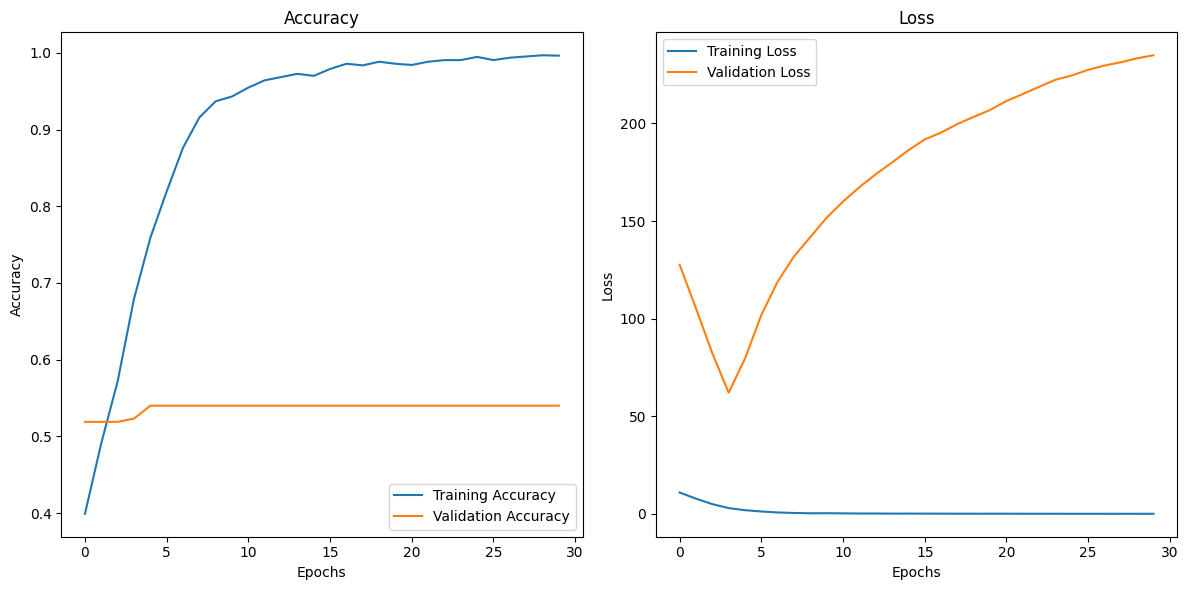

In [30]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


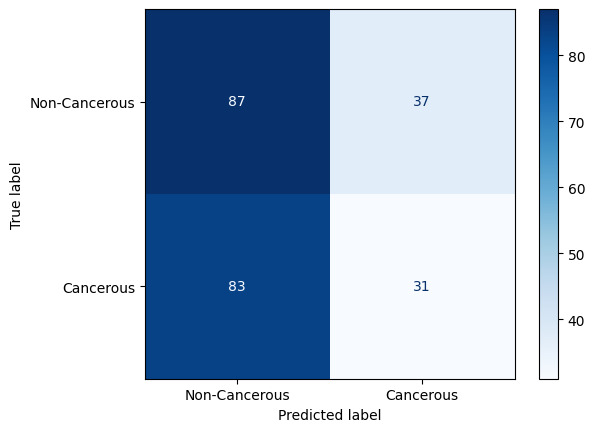

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
y_pred_probs = model_vgg16.predict(test_generator)

# Convert probabilities to binary class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Using InceptionV3

In [7]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load InceptionV3 with pre-trained weights and exclude the top layers
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model_inception.trainable = False

# Build the model
model_inception = Sequential([
    base_model_inception,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Display model summary
model_inception.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [8]:
# Train the model using fit with ImageDataGenerator
history = model_inception.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 624ms/step - accuracy: 0.4912 - loss: 0.8498 - val_accuracy: 0.5992 - val_loss: 0.6789
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - accuracy: 0.5499 - loss: 0.7020 - val_accuracy: 0.5949 - val_loss: 0.6564
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step - accuracy: 0.5951 - loss: 0.6660 - val_accuracy: 0.6456 - val_loss: 0.6346
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 600ms/step - accuracy: 0.5937 - loss: 0.6614 - val_accuracy: 0.6582 - val_loss: 0.6345
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 613ms/step - accuracy: 0.6005 - loss: 0.6497 - val_accuracy: 0.6371 - val_loss: 0.6323
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.6245 - loss: 0.6383 - val_accuracy: 0.6160 - val_loss: 0.6324
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 614ms/step - accuracy: 0.6242 - loss: 0.6354 - val_accuracy: 0.6456 - val_loss: 0.6279
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - accuracy: 0.6521 - loss: 0.6126 - val_accu

In [9]:
# Evaluate on test data after training is complete
test_generator = val_datagen.flow(X_test, y_test, batch_size=32)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 641ms/step


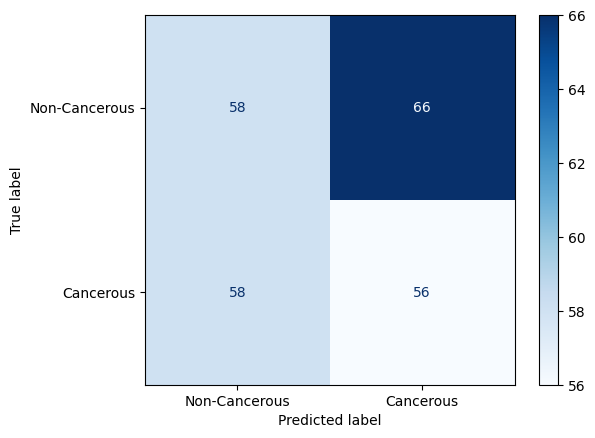

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
y_pred_probs = model_inception.predict(test_generator)

# Convert probabilities to binary class labels
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.show()